In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading dataframes for each protein into python 
Renaming columns to be easily accessable, normalizing the excitation and emission spectra, taking sum of column 

In [2]:
df_mEmerald = pd.read_csv('mEmerald_fpbase_spectra.csv')
df_mEmerald.fillna(0, inplace = True)
df_mTagBFP2 = pd.read_csv('mTagBFP2_fpbase_spectra.csv')
df_mTagBFP2.fillna(0, inplace = True)
df_mCherry = pd.read_csv('mCherry_fpbase_spectra.csv')
df_mCherry.fillna(0, inplace = True)
df_mNeptune2p5 = pd.read_csv('mNeptune2p5_fbpase_spectra.csv')
df_mNeptune2p5.fillna(0, inplace = True)

mEmerald_columns = df_mEmerald.rename(columns ={'mEmerald ex': 'excitation', 'mEmerald em': 'emission'})
mTagBFP2_columns = df_mTagBFP2.rename(columns ={'mTagBFP2 ex': 'excitation', 'mTagBFP2 em': 'emission'})
mCherry_columns = df_mCherry.rename(columns ={'mCherry ex': 'excitation', 'mCherry em': 'emission'})
mNeptune2p5_columns = df_mNeptune2p5.rename(columns ={'mNeptune2.5 ex': 'excitation', 'mNeptune2.5 em': 'emission'})

spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]
for j in range(0,4):
    excitation_column = spectra_list[j]['excitation']
    area = np.trapz(excitation_column, dx = 1)
    normalized = excitation_column/area
    excitation_column = normalized
    spectra_list[j]['excitation'] = normalized
    new_area = np.trapz(excitation_column, dx = 1)
    column = spectra_list[j]['emission']
    area_emission = np.trapz(column, dx = 1)
    normalized_em = column/area_emission
    column = normalized_em
    spectra_list[j]['emission'] = normalized_em
    new_area_em = np.trapz(column, dx = 1)

### Making sure each spectra dataframe has data for 400-900nm

In [3]:
wavelength = 701
for index in range(401, 601):
    mEmerald_columns.loc[len(mEmerald_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 651
for index in range(341, 591):
    mTagBFP2_columns.loc[len(mTagBFP2_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 851
for index in range(621, 671):
    mNeptune2p5_columns.loc[len(mNeptune2p5_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

### Function to solve emission bin area using $i$ and $j$ 
Corresponding lambda_min and lambda_max to the min and max wavelengths in channel i in a list of the 200 total bins 

In [4]:
spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]

def calc_emission_bin(i, j):
    bins_list = [*range(400, 900, 10)]
    total_bins = 4*bins_list 
    df_spectra = spectra_list[j]
    lambda_min = total_bins[i]
    lambda_max = lambda_min + 10
    bin_i = range(lambda_min, lambda_max)
    df_sliced_data = df_spectra.loc[df_spectra['wavelength'].isin(bin_i)]
    # print(df_sliced_data)
    sliced_data_emmision = df_sliced_data['emission']
    emission_bin = np.trapz(sliced_data_emmision)
    # print('Emission bin sum for i = ', i, 'and j = ', j, 'is', emission_bin)
    return emission_bin

### Function to calculate the excitation values from the illumination wavelengths
Excitation value corresponding to excitation wavelengths for each protein: 405nm, 488nm, 561nm, 637nm. Found these values on csv files

In [5]:
def calc_excitation(i, j): 
    illumation_wavelength_list = [405, 488, 561, 637]
    if 0 <= i < 50: 
        illumation_wavelength = illumation_wavelength_list[0]
    elif 50 <= i < 100: 
        illumation_wavelength = illumation_wavelength_list[1]
    elif 100 <= i < 150:
        illumation_wavelength = illumation_wavelength_list[2]
    elif 150 <= i < 200:
        illumation_wavelength = illumation_wavelength_list[3]
    else:
        print('Invalid i value')
    df_sliced = spectra_list[j].loc[spectra_list[j]['wavelength'] == illumation_wavelength]
    excitation_wavelength = df_sliced['excitation'].iloc[0]
    
    return excitation_wavelength

### Function to index over brightness values using a given $j$

In [6]:
def calc_brightness(j):
    # Found brightness values on slack 
    brightness_list = [39.1, 32.38, 15.85, 22.8] 
    brightness = brightness_list[j]
    # print('Brightness value for j = ', j, 'is', brightness)
    return brightness

### Imaging model without before $k$ is specified
Using the average of matrix A (per 50 channels) from this imaging model to calculate K for the real imaging model

In [7]:
def calc_a_ij_wo_k(i, j) :
    k = 1
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a_ij = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a_ij

def form_matrix_A_wo_k():
    A = np.zeros((200, 4))
    for j in range(0, 4):
        for i in range(0, 200):
            A[i, j] = calc_a_ij_wo_k(i, j)
    return A

In [8]:
calc_a_ij_wo_k(10, 0)
# B = form_matrix_A_wo_k() 
# B[10,0]

0.017846902914808855

### Function for the variable $k_i$
We are trying to give each fluorophore a fair chance. Each of our illumination wavelengths is targetted mainly at a specific fluorophore. Experimentally, we can choose the illumination strengths. So, we want to balance out our illumination strengths so that a similar amount of information (photons) is collected from each fluorophore emissions.

Depends on the channel--each set of 50 channels will have a different $k_i$. Could make it depend on the brightnesses.

In [9]:
def calc_k_strength(i, desired_photons):
        A_constant_k = form_matrix_A_wo_k()
        illumination_one = A_constant_k[0:50, 0:4]
        illumination_two = A_constant_k[50:100, 0:4]
        illumination_three = A_constant_k[100:150, 0:4]
        illumination_four = A_constant_k[150:200, 0:4]
        if 0 <= i < 50: 
                sliced_average = np.average(illumination_one)
                k = 1/(sliced_average) * desired_photons
        elif 50 <= i < 100:
                sliced_average = np.average(illumination_two)
                k = 1/(sliced_average) *desired_photons
        elif 100 <= i < 150:
                sliced_average = np.average(illumination_three)
                k = 1/(sliced_average) * desired_photons
        elif 150 <= i < 200:
                sliced_average = np.average(illumination_four)
                k = 1/(sliced_average) * desired_photons
        return k 

In [10]:
calc_k_strength(10, 100)

30740.88858655248

### Imaging model with $k$ specified
Created a list of k values since there are only four total (reduces run time)

In [11]:
def form_k_list(desired_photons):
    k_list = []
    for i in [0, 50, 100, 150]:
        k = calc_k_strength(i, desired_photons)
        k_list.append(k)
        
    return k_list

def calc_a_ij(i, j, k_list):
    # Replaced line below because it is too computationally intensive
    # k = calc_k_strength(i, desired_photons)
    if 0 <= i < 50: 
        k = k_list[0]
    elif 50 <= i < 100:
        k = k_list[1]
    elif 100 <= i < 150:
        k = k_list[2]
    elif 150 <= i < 200:
        k = k_list[3]
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a_ij = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a_ij

def form_matrix_A(desired_photons):
    k_list = form_k_list(desired_photons)
    A = np.zeros((200, 4))
    for j in range(0, 4):
        for i in range(0, 200):
            A[i, j] = calc_a_ij(i, j, k_list)
    return A

### Created a list of matrices so we are now able to easily create multiple "A" matrices for varying desired photon values. 
Can choose a specific one by indexing over the list 

In [12]:
def calc_A_for_varying_photons(desired_photons_list):
    # Input: list of average detected photons desired
    # Output: list of corresponding A matrices
    matrix_A_list = []
    for desired_photons in desired_photons_list:
        A = form_matrix_A(desired_photons)
        matrix_A_list.append(A)

    return matrix_A_list

### Create a vector consisting of some concentration of each fluorophore
The concentrations don't have to all be the same. Modeling our imaging system -- using one of each fluorophore in this example. Each index corresponds to a fluorophore

In [13]:
x = [1, 1, 1, 1] ##might have to switch orientation if error (transpose)

### Function to calculate FOM from $A$ and $x$ 
1. Multiplying Matrix A by Vector x (calculating the measurements of y using imaging model)
2. Transposing A using simple command '.T'
3. Creating diagonal matrix of 1/y
4. Multiply all three matrices and compute the fisher information matrix
5. Inversing the fisher information matrix. 
6. Take out all the diagonal elements in the fisher information matrix (these are the CRLB numbers).
7. Square root all the CRLB numbers.
8. Divide the fluorophore concentrations by the square-rooted CRLB numbers (would have to change code if don't use 1 for each concentration)

If you inverse the fisher information matrix and multiply it by the initial fisher information matrix, should get a diagonal matrix of all 1's on the diagonal (and the rest of the elements should be 0. Ours are very small numbers that would round to zero).

i.e. (idk = FIM_inverse @ FIM) should result in that

In [14]:
def calc_FOM(A, x):
    y = A @ x 
    y_reshaped = np.reshape(y, (200, 1))
    transposed_A = A.T
    FIM_y = 1/y
    FIM_y[FIM_y == np.inf] = 0
    diagonal_matrix = np.diag(FIM_y)
    FIM = transposed_A @ diagonal_matrix @ A
    FIM_inverse = np.linalg.inv(FIM)
    CRLB_0 = FIM_inverse[0,0] 
    CRLB_1 = FIM_inverse[1,1]
    CRLB_2 = FIM_inverse[2,2]
    CRLB_3 = FIM_inverse[3,3]
    CRLB_list = [CRLB_0, CRLB_1, CRLB_2, CRLB_3]
    sqrt_CRLB_list = np.sqrt(CRLB_list)
    FOM_list = [1/i for i in sqrt_CRLB_list] #would have to change this line of code if don't use 1 for each concentration
    
    return FOM_list


### Forming our imaging models based on the number of detected photons

Using time function to check how long each process takes to run

In [15]:
import time

st = time.time()

k_list = form_k_list(100)
print(f"List of k values: {k_list}")
a = calc_a_ij(0, 0, k_list)
print(f"a: {a}")

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


List of k values: [30740.88858655248, 36033.13727501114, 75451.7982786767, 497698.88987024943]
a: 0.0
Execution time: 1.046389102935791 seconds


In [16]:
st = time.time()

A_list = calc_A_for_varying_photons([100, 200, 300])

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 4.1145219802856445 seconds


### Calculating the average number of detected photons
Checking if the number of photons matches what we would expect

In [17]:
def calc_avg_detected_photons(A):
    avg_photons_detected_list = []
    for illum_count in range(4):
        # start = 50 * illum_count
        # end = 50 * (illum_count + 1)
        # print(f"Start row: {start}, End row: {end}")
        A_section = A[50 * illum_count : 50 * (illum_count + 1), :]
        avg_photons_detected = np.average(A_section)
        avg_photons_detected_list.append(avg_photons_detected)

    return avg_photons_detected_list

### Function to determine average photons detected using a for-loop 

In [ ]:
def calc_multiple_photons_detected(desired_photons_list):
    # Output: a list of the photons detected on average for each of the fluorophores 
    #       (i.e fist list corresponds to the avg photons detected for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) 
    photons_detected_list = []
    for matrix in A_for_desired_photons:
        photons_detected_varying = calc_avg_detected_photons(matrix)
        photons_detected_list.append(photons_detected_varying)
    # return photons_detected_list
    multiple_photons_detected_list = []
    for j in range(4):
        photon_spectra = [item[j] for item in photons_detected_list]
        multiple_photons_detected_list.append(photon_spectra)
    
    return multiple_photons_detected_list 
        

multiple_photons_detected_list = calc_multiple_photons_detected([100, 200, 300]) 
print(multiple_photons_detected_list)

In [18]:
A = form_matrix_A(200)
calc_avg_detected_photons(A)

[199.99999999999991, 200.00000000000003, 200.00000000000003, 200.0]

### Plotting the FOMs against avg # of detected photons for desired_photons = 100, 200, 300
Using $x_j$ = [1, 1, 1, 1]

### Function to input desired_photon_list and have a list of multiple FOMs for each fluorophore returned 
Function will solve for matrix A for each of the desired photon values, then solve for the FOMs for each of the matrices, then return a list of multiple values of FOMs for each fluorophore. Turns the lists of FOMs for each fluorophore into a function that returns a list of lists, with each list containing the FOMs for a specific fluorophore and the inputted desired photon values

In [110]:
def calc_multiple_FOMs(desired_photons_list, x):
    # Input: two lists 
    # Output: returns a list of the FOMs for each of the fluorophoress 
    #       (i.e fist list corresponds to the FOMs for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) # this produces a list of matrices, each 200x4
    # x = [1, 1, 1, 1] # concentration of each fluorophore
    FOM_list_varying_photons = []
    for matrix in A_for_desired_photons: # for each matrix in A_for_desired_photons
        calculated_FOMs = calc_FOM(matrix, x) # do this. it will loop on its own (that's what the for-loop is for)
        FOM_list_varying_photons.append(calculated_FOMs) # append the FOM list you get for each matrix into the empty list you created
    FOM_spectra_list = []
    for j in range(4):
        FOM_spectra = [item[j] for item in FOM_list_varying_photons]
        FOM_spectra_list.append(FOM_spectra)
    
    return FOM_spectra_list 


In [93]:
def calc_avg_detected_photons_per_fluor(A):
    # Input: 200x4 numpy array
    # Output: list of average photons detected
    avg_photons_detected_list = []
    for j in range(4):
        A_section = A[:, j]
        avg_photons_detected = np.average(A_section)
        avg_photons_detected_list.append(avg_photons_detected)

    return avg_photons_detected_list

calc_avg_detected_photons_per_fluor(A)

[225.15167228636608, 168.84383722782076, 102.30197673088698, 303.7025137549262]

In [99]:
def calc_photons_detected_per_fluor(desired_photons_list):
    # Input: list of desired photons 
    # Output: a list of the photons detected on average for each of the fluorophores 
    #       (i.e fist list corresponds to the avg photons detected for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) 
    photons_detected_list = []
    for matrix in A_for_desired_photons:
        photons_detected = calc_avg_detected_photons_per_fluor(matrix)
        photons_detected_list.append(photons_detected)
    multiple_photons_detected_list = []
    for j in range(4):
        photon_spectra = [item[j] for item in photons_detected_list]
        multiple_photons_detected_list.append(photon_spectra)
    
    return multiple_photons_detected_list 


### Generating a large set of data to later plot subsets of the data

In [149]:
desired_photons_list = [*range(1000, 100000, 1000)]
FOM_spectra_list = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list = calc_photons_detected_per_fluor(desired_photons_list)

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


In [150]:
print(len(desired_photons_list))

99


### I like this one

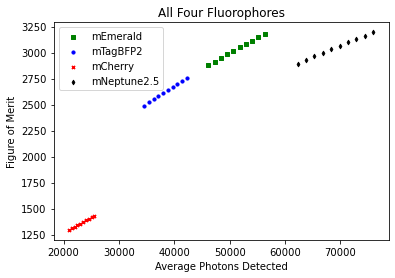

In [159]:
start_idx = 40
end_idx = 50
FOM_spectra_list_subset = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset[j] = FOM_spectra_list[j][start_idx : end_idx]
    avg_photons_detected_list_subset[j] = avg_photons_detected_list[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset[0], FOM_spectra_list_subset[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset[1], FOM_spectra_list_subset[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset[2], FOM_spectra_list_subset[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_subset[3], FOM_spectra_list_subset[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('Figure of Merit')
plt.xlabel('Average Photons Detected')
plt.title('All Four Fluorophores')
plt.savefig('Figures/Average Photons Detected vs FOMs for Same 10 Index Range All Fluorophores.pdf')
plt.show()


### I like this one too

In [161]:
desired_photons_list = [*range(1000, 100000, 1000)]
FOM_spectra_list_no_mNeptune = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 0])
avg_photons_detected_list_no_mNeptune = calc_photons_detected_per_fluor(desired_photons_list)

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


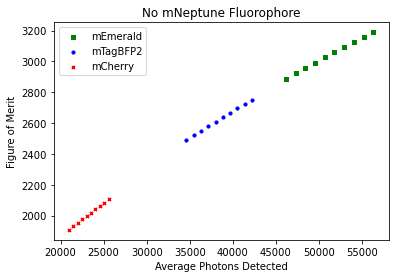

In [163]:
start_idx = 40
end_idx = 50
FOM_spectra_list_subset_no_mNeptune = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset_no_mNeptune = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset_no_mNeptune[j] = FOM_spectra_list_no_mNeptune[j][start_idx : end_idx]
    avg_photons_detected_list_subset_no_mNeptune[j] = avg_photons_detected_list_no_mNeptune[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[0], FOM_spectra_list_subset_no_mNeptune[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[1], FOM_spectra_list_subset_no_mNeptune[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[2], FOM_spectra_list_subset_no_mNeptune[2], s=10, c='r', marker="x", label='mCherry')
# ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[3], FOM_spectra_list_subset_no_mNeptune[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('Figure of Merit')
plt.xlabel('Average Photons Detected')
plt.title('No mNeptune Fluorophore')
plt.savefig('Figures/Average Photons Detected vs FOMs for Same 10 Index Range No mNeptune2p5.pdf')
plt.show()

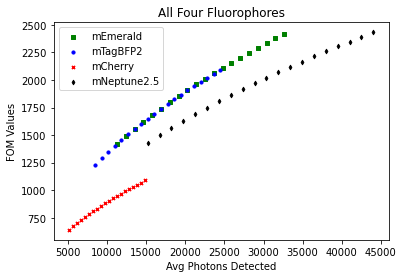

In [160]:
start_idx = 9
end_idx = 29
FOM_spectra_list_subset = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset[j] = FOM_spectra_list[j][start_idx : end_idx]
    avg_photons_detected_list_subset[j] = avg_photons_detected_list[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset[0], FOM_spectra_list_subset[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset[1], FOM_spectra_list_subset[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset[2], FOM_spectra_list_subset[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_subset[3], FOM_spectra_list_subset[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('All Four Fluorophores')
plt.savefig('Figures/Avg Photons Detected vs FOMs for All Fluorophores.pdf')
plt.show()

### Plot each fluorophore with points/FOMs for desired photons = [*range(100, 3000, 100)] all on same plot

In [122]:
desired_photons_list = [*range(100, 3000, 100)]
FOM_spectra_list = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list = calc_photons_detected_per_fluor(desired_photons_list)

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


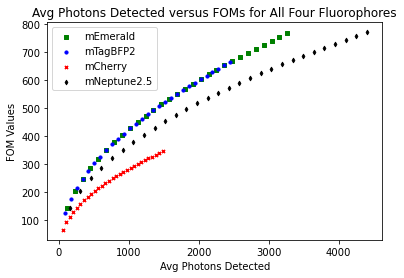

In [107]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list[0], FOM_spectra_list[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list[1], FOM_spectra_list[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list[2], FOM_spectra_list[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list[3], FOM_spectra_list[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Avg Photons Detected vs FOMs.pdf')
plt.show()


### (Old method) Plotting desired photon list vs FOMs for all fluorophores and desired photons = [*range(100, 3000, 100)] all on same plot

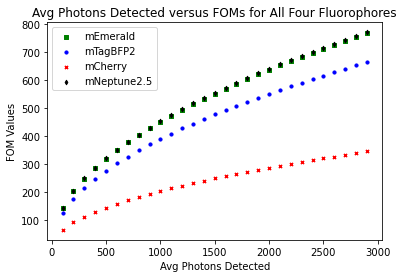

In [123]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(desired_photons_list, FOM_spectra_list[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(desired_photons_list, FOM_spectra_list[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(desired_photons_list, FOM_spectra_list[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(desired_photons_list, FOM_spectra_list[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs.pdf')
plt.show()


### Plotting Avg Photons Detected vs FOMs for desired_photons = [*range(1000, 10000, 1000)] & x = [1, 1, 1, 1]

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


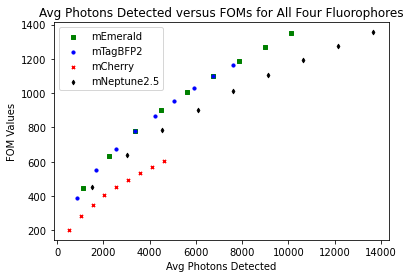

In [124]:
desired_photons_list = [*range(1000, 10000, 1000)]
FOM_spectra_list_large_range = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list_large_range = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_large_range[0], FOM_spectra_list_large_range[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_large_range[1], FOM_spectra_list_large_range[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_large_range[2], FOM_spectra_list_large_range[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_large_range[3], FOM_spectra_list_large_range[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for Large Range.pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for desired_photons = [*range(1000, 100000, 1000)]

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


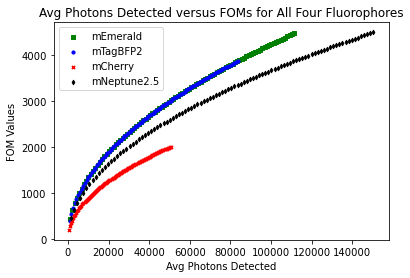

In [125]:
desired_photons_list = [*range(1000, 100000, 1000)]
FOM_spectra_list_huge_range = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list_huge_range = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_huge_range[0], FOM_spectra_list_huge_range[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_huge_range[1], FOM_spectra_list_huge_range[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_huge_range[2], FOM_spectra_list_huge_range[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_huge_range[3], FOM_spectra_list_huge_range[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for Ranging to 100000.pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for desired_photons = [*range(100000, 200000, 10000)]

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


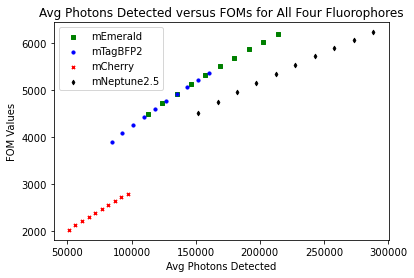

In [126]:
desired_photons_list = [*range(100000, 200000, 10000)]
FOM_spectra_list_range_100000_to_200000 = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list_range_100000_to_200000 = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_range_100000_to_200000[0], FOM_spectra_list_range_100000_to_200000[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_range_100000_to_200000[1], FOM_spectra_list_range_100000_to_200000[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_range_100000_to_200000[2], FOM_spectra_list_range_100000_to_200000[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_range_100000_to_200000[3], FOM_spectra_list_range_100000_to_200000[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for Ranging 100000 to 200000.pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for desired_photons = [*range(500000, 1000000, 100000)]

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


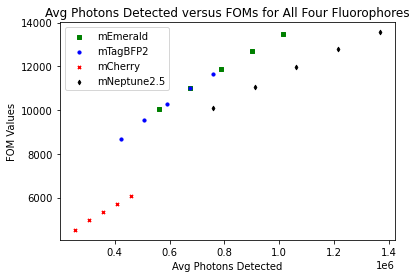

In [127]:
desired_photons_list = [*range(500000, 1000000, 100000)]
FOM_spectra_list_range_500000_to_1000000 = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list_range_500000_to_1000000 = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_range_500000_to_1000000[0], FOM_spectra_list_range_500000_to_1000000[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_range_500000_to_1000000[1], FOM_spectra_list_range_500000_to_1000000[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_range_500000_to_1000000[2], FOM_spectra_list_range_500000_to_1000000[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_range_500000_to_1000000[3], FOM_spectra_list_range_500000_to_1000000[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for Ranging 500000 to 1000000.pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for x = [0, 1, 1, 1]

In [114]:
desired_photons_list = [*range(100, 1000, 100)]
concentration_0_1_1_1 = calc_multiple_FOMs(desired_photons_list, [0, 1, 1, 1])
concentration_0_1_1_1_photons = calc_photons_detected_per_fluor(desired_photons_list)


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


[[2382.0181284562573, 3368.682343081416, 4125.776423036365, 4764.036256912515, 5326.3544588650175, 5834.728972777182, 6302.227586342764, 6737.364686162832, 7146.0543853687695], [129.73862788726467, 183.47812712184597, 224.71389520501486, 259.47725577452934, 290.10439126347376, 317.79343825261844, 343.2561448284516, 366.95625424369194, 389.2158836617941], [64.92683121898445, 91.82040527179667, 112.45657044573016, 129.8536624379689, 145.18080816930475, 159.037607102317, 171.78024882089744, 183.64081054359335, 194.78049365695327], [143.35082317802897, 202.72867831571597, 248.2909090511684, 286.70164635605795, 320.54218525662526, 351.13637099410704, 379.2706283654584, 405.45735663143194, 430.0524695340869]]


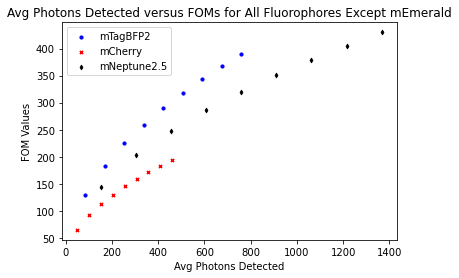

In [129]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# ax1.scatter(concentration_0_1_1_1_photons[0], concentration_0_1_1_1[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(concentration_0_1_1_1_photons[1], concentration_0_1_1_1[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(concentration_0_1_1_1_photons[2], concentration_0_1_1_1[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(concentration_0_1_1_1_photons[3], concentration_0_1_1_1[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Fluorophores Except mEmerald')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for [0, 1, 1, 1].pdf')
plt.show()


### Plotting Avg Photons Detected vs FOMs for x = [1, 0, 1, 1]

In [118]:
desired_photons_list = [*range(100, 1000, 100)]
concentration_1_0_1_1 = calc_multiple_FOMs(desired_photons_list, [1, 0, 1, 1])
concentration_1_0_1_1_photons = calc_photons_detected_per_fluor(desired_photons_list)


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


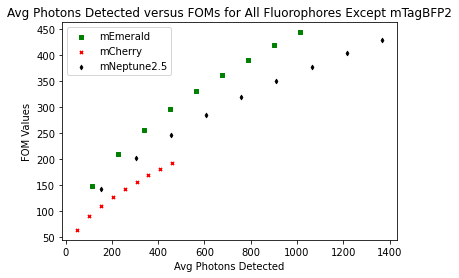

In [130]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(concentration_1_0_1_1_photons[0], concentration_1_0_1_1[0], s=10, c='g', marker="s", label='mEmerald')
# ax1.scatter(concentration_1_0_1_1_photons[1], concentration_1_0_1_1[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(concentration_1_0_1_1_photons[2], concentration_1_0_1_1[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(concentration_1_0_1_1_photons[3], concentration_1_0_1_1[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Fluorophores Except mTagBFP2')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for [1, 0, 1, 1].pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for x = [1, 1, 0, 1]. Correct way to format plot

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


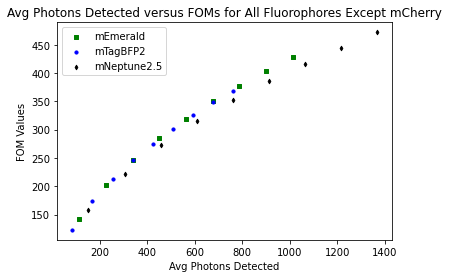

In [131]:
desired_photons_list = [*range(100, 1000, 100)]
concentration_1_1_0_1 = calc_multiple_FOMs(desired_photons_list, [1, 1, 0, 1])
concentration_1_1_0_1_photons = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(concentration_1_1_0_1_photons[0], concentration_1_1_0_1[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(concentration_1_1_0_1_photons[1], concentration_1_1_0_1[1], s=10, c='b', marker="o", label='mTagBFP2')
# ax1.scatter(concentration_1_0_1_1_photons[2], concentration_1_0_1_1[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(concentration_1_1_0_1_photons[3], concentration_1_1_0_1[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('Figure of Merit')
plt.xlabel('Average Photons Detected')
plt.title('All Fluorophores Except mCherry')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for [1, 1, 0, 1].pdf')
plt.show()

### Plotting Avg Photons Detected vs FOMs for x = [1, 1, 1, 0]

/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_36975/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


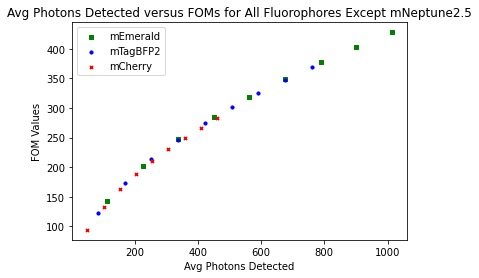

In [132]:
desired_photons_list = [*range(100, 1000, 100)]
concentration_1_1_1_0 = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 0])
concentration_1_1_1_0_photons = calc_photons_detected_per_fluor(desired_photons_list)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(concentration_1_1_1_0_photons[0], concentration_1_1_1_0[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(concentration_1_1_1_0_photons[1], concentration_1_1_1_0[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(concentration_1_1_1_0_photons[2], concentration_1_1_1_0[2], s=10, c='r', marker="x", label='mCherry')
# ax1.scatter(concentration_1_1_1_0_photons[3], concentration_1_1_1_0[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Fluorophores Except mNeptune2.5')
plt.savefig('Figures/Total Avg Photons Detected vs FOMs for [1, 1, 1, 0].pdf')
plt.show()

For mEmerald (Old way)

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mEmerald')

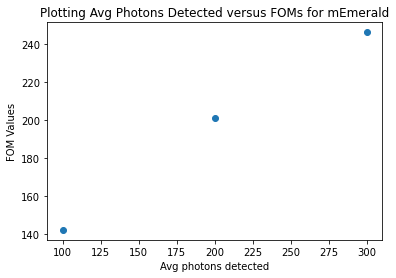

In [29]:
plt.scatter(x = [Avg_photons_100[0], Avg_photons_200[0], Avg_photons_300[0]], y = [FOM_for_100[0], FOM_for_200[0], FOM_for_300[0]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mEmerald')

For mTagBFP2 (Old way)

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mTagBFP2')

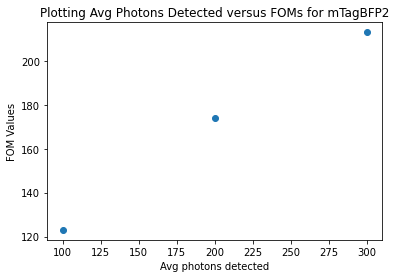

In [30]:
plt.scatter(x = [Avg_photons_100[1], Avg_photons_200[1], Avg_photons_300[1]], y = [FOM_for_100[1], FOM_for_200[1], FOM_for_300[1]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mTagBFP2')

For mCherry (Old way)

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mCherry')

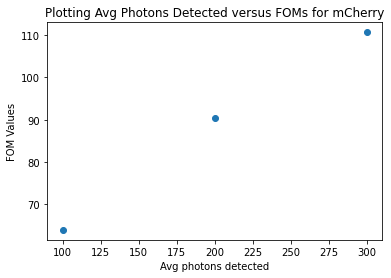

In [31]:
plt.scatter(x = [Avg_photons_100[2], Avg_photons_200[2], Avg_photons_300[2]], y = [FOM_for_100[2], FOM_for_200[2], FOM_for_300[2]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mCherry')

For mNeptune2.5 (Old way)

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mNeptune2.5')

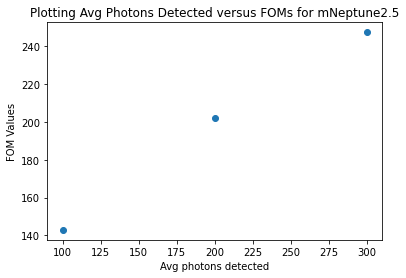

In [32]:
plt.scatter(x = [Avg_photons_100[3], Avg_photons_200[3], Avg_photons_300[3]], y = [FOM_for_100[3], FOM_for_200[3], FOM_for_300[3]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mNeptune2.5')

Work on combining all four plots into single plot and should have about 20 desired photon values for each fluorophore (looking for a platoe on the graph which shows the optimal illumination strength). Can't know for sure because would need to take into account other factors in the imaging model (i.e. bleaching). Looking to create plot to give complete picture of how well imaging system works. Maybe make each fluorophore a certain color

### Plotting FOMs and Avg Photons Detected for desired_photons = 100, 200, 300 for all four fluorophores on one graph (Old way)

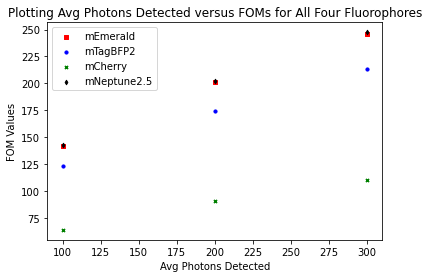

In [33]:
avg_photons_detected_mEmerald = [Avg_photons_100[0], Avg_photons_200[0], Avg_photons_300[0]]
FOMs_mEmerald = [FOM_for_100[0], FOM_for_200[0], FOM_for_300[0]]
avg_photons_detected_mTag = [Avg_photons_100[1], Avg_photons_200[1], Avg_photons_300[1]]
FOMs_mTag = [FOM_for_100[1], FOM_for_200[1], FOM_for_300[1]]
avg_photons_detected_mCherry = [Avg_photons_100[2], Avg_photons_200[2], Avg_photons_300[2]]
FOMs_mCherry = [FOM_for_100[2], FOM_for_200[2], FOM_for_300[2]]
avg_photons_detected_mNeptune = [Avg_photons_100[3], Avg_photons_200[3], Avg_photons_300[3]]
FOMs_mNeptune = [FOM_for_100[3], FOM_for_200[3], FOM_for_300[3]]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_mEmerald, FOMs_mEmerald, s=10, c='r', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_mTag, FOMs_mTag, s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_mCherry, FOMs_mCherry, s=10, c='g', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_mNeptune, FOMs_mNeptune, s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Plotting Avg Photons Detected versus FOMs for All Four Fluorophores')
plt.show()

Can look into plotting the emission spectra of the fluorophores -- might display overlap/crosstalk, which lowers FOMs